**[Updated 4/9/2025]**
* Changed from train_test_split() on a single dataset (imbalanced byarticle_clean.tsv) to train is imbalanced, test is balanced (separete test dataset).

* Added tf-idf with ros and styling.
* Added lemmatization for both tf-idf and countvect.


# Overview

Testing different versions of NB, by applying TF, CountVectorizer, ROS.



In [72]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, balanced_accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd
from src.utils import load_cleaned_data, metrics, store_metrics, plot_confusion_matrix

# Adding both TF and CountVectorizer

* CountVectorizer() → raw word counts

* TfidfVectorizer() → weighted terms


In [73]:
def tfidf(X_train, X_test):
    vectorizer = TfidfVectorizer(max_features=10000, stop_words="english")
    return vectorizer.fit_transform(X_train), vectorizer.transform(X_test)

def count_vectorizer(X_train, X_test):
    vectorizer = CountVectorizer(max_features=10000, stop_words="english")
    return vectorizer.fit_transform(X_train), vectorizer.transform(X_test)

In [74]:
# Uses MultinomialNB for the baseline model
def naive_bayes(X_train_tfidf, X_test_tfidf, y_train):
  model = MultinomialNB()
  model.fit(X_train_tfidf, y_train)
  y_pred = model.predict(X_test_tfidf)
  return model, y_pred

# Comparison approach: TF & CountVect
1. Store the evaluation scores for both methods instead of just printing them.

2. Compare the results (e.g., based on F1-score or AUC, depending on what you value more).



--- Naive Bayes with TF-IDF ---
Accuracy: 0.54
Balanced Accuracy: 0.54
Precision: 0.86
Recall: 0.10
F1: 0.17
AUC: 0.75


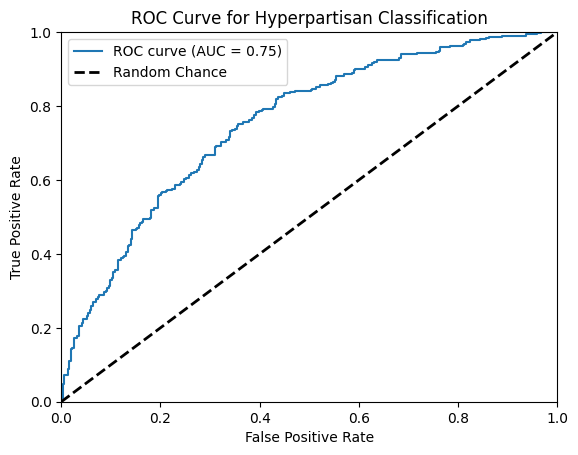

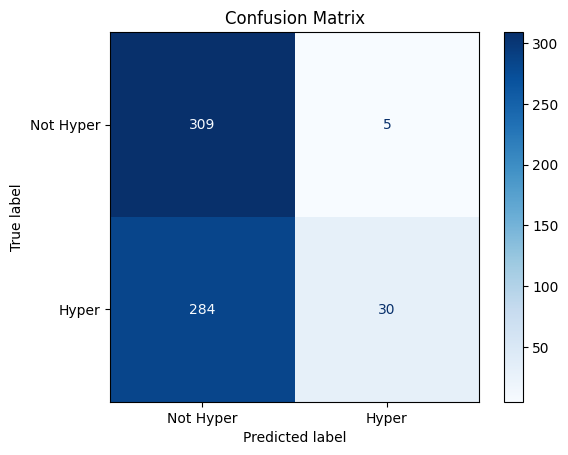


--- Naive Bayes with CountVectorizer ---
Accuracy: 0.72
Balanced Accuracy: 0.72
Precision: 0.70
Recall: 0.77
F1: 0.73
AUC: 0.79


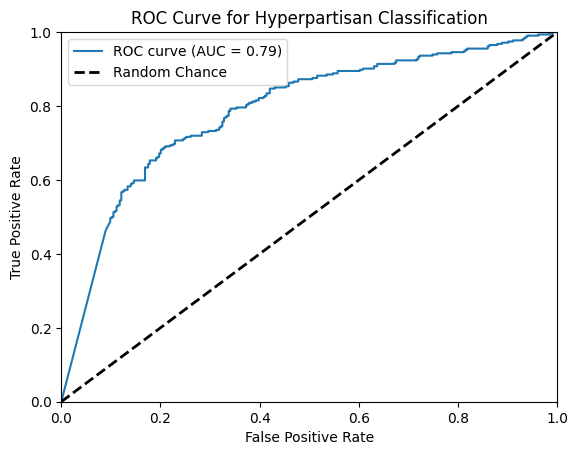

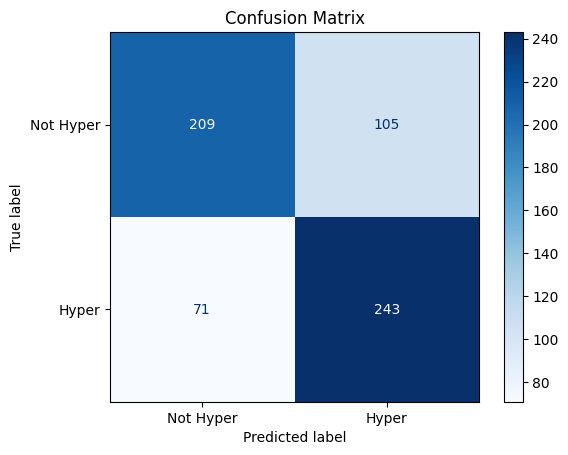


=== Comparison Table ===
         Model            Setup  Accuracy  Balanced Accuracy  Precision  \
0  Naive Bayes           TF-IDF      0.54               0.54      0.857   
1  Naive Bayes  CountVectorizer      0.72               0.72      0.698   

   Recall  F1 Score    AUC  
0   0.096     0.172  0.753  
1   0.774     0.734  0.788  


In [75]:
# Load separate train and test files
train_df = pd.read_csv("data/byarticle_clean.tsv", sep="\t")
test_df = pd.read_csv("data/byarticle_clean_test.tsv", sep="\t")


X_train = train_df['full_text']
y_train = train_df['label']

X_test = test_df['full_text']
y_test = test_df['label']



# Store results for summary
results = []

# Vectorization methods
vectorizers = {
    "TF-IDF": tfidf,
    "CountVectorizer": count_vectorizer
}

for vec_name, vectorizer_fn in vectorizers.items():
    X_train_vec, X_test_vec = vectorizer_fn(X_train, X_test)
    model, y_pred = naive_bayes(X_train_vec, X_test_vec, y_train)
    y_proba = model.predict_proba(X_test_vec)[:, 1]

    print(f"\n--- Naive Bayes with {vec_name} ---")
    metrics(y_test, y_pred, y_proba)  # uses your existing custom function
    plot_confusion_matrix(y_test, y_pred)

    setup_label = f"{vec_name}"
    store_metrics(results, model_name="Naive Bayes", setup_label=setup_label,
                  y_test=y_test, y_pred=y_pred, y_pred_proba=y_proba)

results_df = pd.DataFrame(results)
print("\n=== Comparison Table ===")
print(results_df)

As seen from the table, TF-IDf is not a good fit for NB.

# Testing with ROS

resusing prev. functions.


In [76]:
from imblearn.over_sampling import RandomOverSampler


=== Naive Bayes with TF-IDF + ROS ===
              precision    recall  f1-score   support

           0       0.80      0.48      0.60       314
           1       0.63      0.88      0.74       314

    accuracy                           0.68       628
   macro avg       0.72      0.68      0.67       628
weighted avg       0.72      0.68      0.67       628

Accuracy: 0.68
Balanced Accuracy: 0.68
Precision: 0.63
Recall: 0.88
F1: 0.74
AUC: 0.81


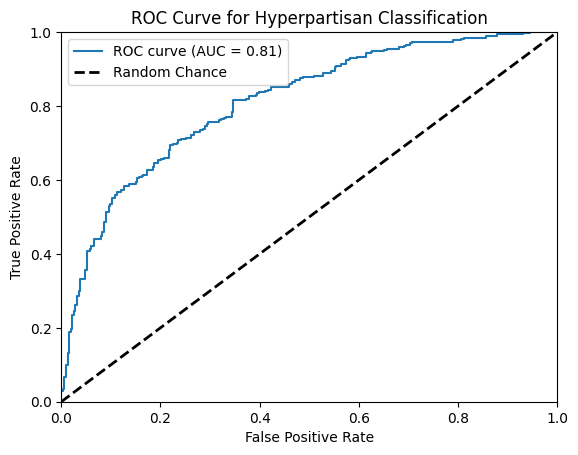

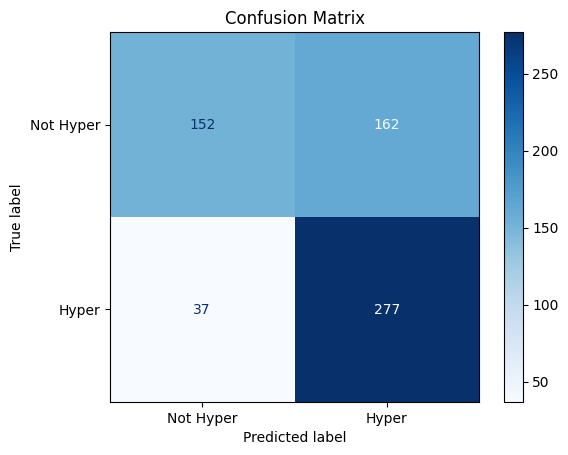


=== Naive Bayes with CountVectorizer + ROS ===
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       314
           1       0.70      0.76      0.73       314

    accuracy                           0.71       628
   macro avg       0.72      0.71      0.71       628
weighted avg       0.72      0.71      0.71       628

Accuracy: 0.71
Balanced Accuracy: 0.71
Precision: 0.70
Recall: 0.76
F1: 0.73
AUC: 0.78


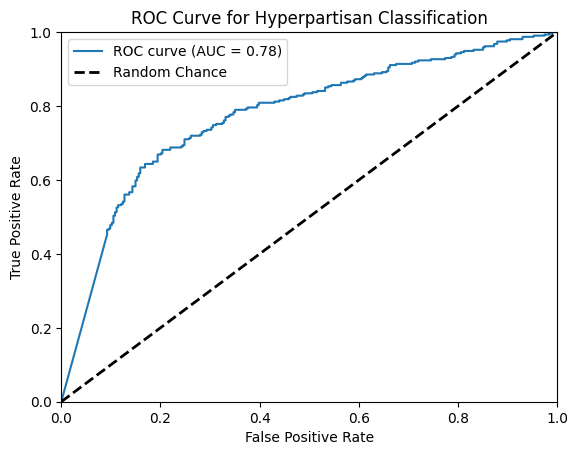

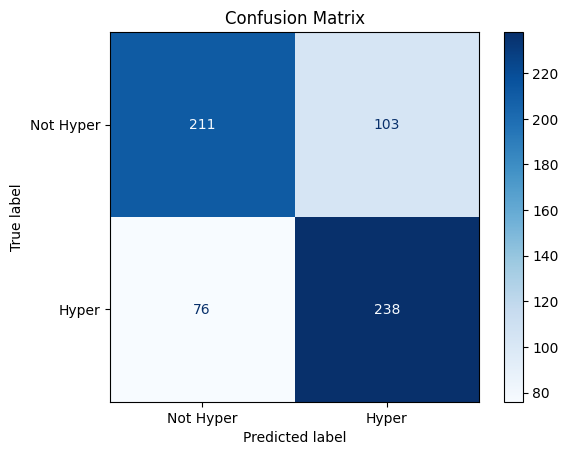


=== Comparison Table ===
         Model                  Setup  Accuracy  Balanced Accuracy  Precision  \
0  Naive Bayes                 TF-IDF     0.540              0.540      0.857   
1  Naive Bayes        CountVectorizer     0.720              0.720      0.698   
2  Naive Bayes           TF-IDF + ROS     0.683              0.683      0.631   
3  Naive Bayes  CountVectorizer + ROS     0.715              0.715      0.698   

   Recall  F1 Score    AUC  
0   0.096     0.172  0.753  
1   0.774     0.734  0.788  
2   0.882     0.736  0.810  
3   0.758     0.727  0.776  


In [77]:
# Loop through vectorizers
for vec_name, vectorizer_fn in vectorizers.items():
    # Vectorize train/test
    X_train_vec, X_test_vec = vectorizer_fn(X_train, X_test)

    # Apply Random OverSampler to address imbalance
    ros = RandomOverSampler(random_state=0)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vec, y_train)

    # Train Naive Bayes model
    model, y_pred = naive_bayes(X_train_resampled, X_test_vec, y_train_resampled)
    y_proba = model.predict_proba(X_test_vec)[:, 1]

    # Evaluation output
    print(f"\n=== Naive Bayes with {vec_name} + ROS ===")
    print(classification_report(y_test, y_pred))
    metrics(y_test, y_pred, y_proba)
    plot_confusion_matrix(y_test, y_pred)

    # Track metrics for comparison table
    setup_label = f"{vec_name} + ROS"
    store_metrics(results, model_name="Naive Bayes", setup_label=setup_label,
                  y_test=y_test, y_pred=y_pred, y_pred_proba=y_proba)

# Summary table
results_df = pd.DataFrame(results)
print("\n=== Comparison Table ===")
print(results_df)

# Analyze after improved with ROS

TF-IDF without ROS performs poorly in both

    Very low recall (0.096–0.083), meaning it fails to catch positive cases.

    Likely caused by:

        Feature sparsity

        Imbalance in training

        TF-IDF overfitting on majority class

CountVectorizer consistently performs better:
Accuracy: ~0.72–0.73

F1 Score: ~0.63–0.73

ROC AUC: ~0.76–0.78

# Adding styling

In [78]:
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

Extra -> Lemmetization (Optional, 1.3 min)

In [79]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatize_text(text):
    return " ".join([token.lemma_ for token in nlp(text) if not token.is_stop and not token.is_punct])

# Apply to both train and test
train_df["lemmatized_text"] = train_df["full_text"].apply(lemmatize_text)
test_df["lemmatized_text"] = test_df["full_text"].apply(lemmatize_text)

# Then use `lemmatized_text` instead of `full_text` in TF-IDF or CountVectorizer


train_df.to_csv("data/byarticle_train_lemmatized.tsv", sep="\t", index=False)
test_df.to_csv("data/byarticle_test_lemmatized.tsv", sep="\t", index=False)


Main code

* to switch between lemmatization or not, change text_column

In [86]:
# === Define text + style inputs ===
#text_column = "full_text"
text_column = "lemmatized_text"  # could be changed for lemmatized_text or full_text
style_features = ["uppercase_ratio", "exclamation_count", "avg_sentence_length"]

X_train_text = train_df[text_column]
y_train = train_df["label"]
X_train_style = train_df[style_features]

X_test_text = test_df[text_column]
y_test = test_df["label"]
X_test_style = test_df[style_features]

In [81]:
def combine_text_and_style(vectorizer_fn, X_train_text, X_test_text, X_train_style, X_test_style):
    # Vectorize text
    X_train_vec = vectorizer_fn.fit_transform(X_train_text)
    X_test_vec = vectorizer_fn.transform(X_test_text)

    # Scale style features
    scaler = MinMaxScaler()
    X_train_style_scaled = scaler.fit_transform(X_train_style)
    X_test_style_scaled = scaler.transform(X_test_style)

    # Convert style to sparse
    X_train_style_sparse = csr_matrix(X_train_style_scaled)
    X_test_style_sparse = csr_matrix(X_test_style_scaled)

    # Combine text + style
    X_train_combined = hstack([X_train_vec, X_train_style_sparse])
    X_test_combined = hstack([X_test_vec, X_test_style_sparse])

    print("Text vector shape:", X_train_vec.shape)
    print("Style vector shape:", X_train_style_sparse.shape)
    print("Combined shape:", X_train_combined.shape)

    return X_train_combined, X_test_combined

#Testing with TF and CountVec

Text vector shape: (645, 10000)
Style vector shape: (645, 3)
Combined shape: (645, 10003)

--- Naive Bayes + TF-IDF + Style + ROS ---
Accuracy: 0.68
Balanced Accuracy: 0.68
Precision: 0.62
Recall: 0.90
F1: 0.74
AUC: 0.82


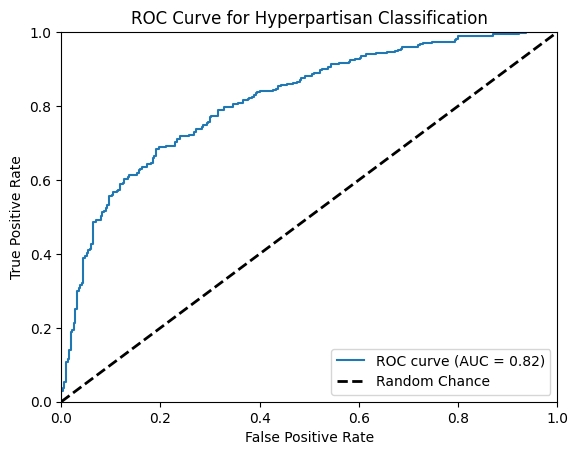

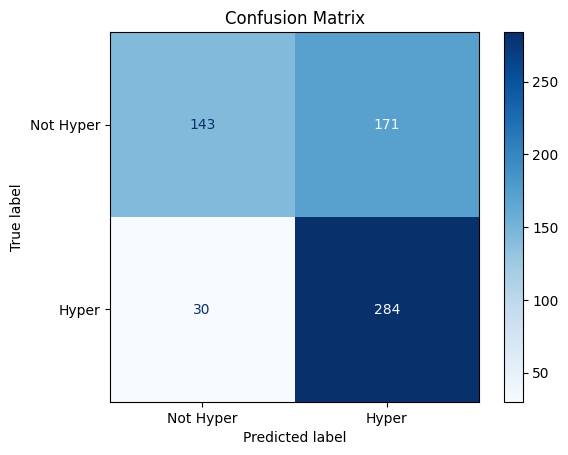

In [87]:
# Use TF-IDF instead of CountVectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=10000)

# Combine text + style
X_train_comb, X_test_comb = combine_text_and_style(
    vectorizer,
    X_train_text, X_test_text,
    X_train_style, X_test_style
)

# Oversample
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_comb, y_train)

# Train model
model, y_pred = naive_bayes(X_train_resampled, X_test_comb, y_train_resampled)
y_proba = model.predict_proba(X_test_comb)[:, 1]

# Evaluate
print("\n--- Naive Bayes + TF-IDF + Style + ROS ---")
metrics(y_test, y_pred, y_proba)
plot_confusion_matrix(y_test, y_pred)
store_metrics(results, "Naive Bayes", "TF-IDF + Style + ROS + lemmatization", y_test, y_pred, y_proba)


Text vector shape: (645, 10000)
Style vector shape: (645, 3)
Combined shape: (645, 10003)

--- Naive Bayes + CountVectorizer + Style + ROS ---
Accuracy: 0.71
Balanced Accuracy: 0.71
Precision: 0.69
Recall: 0.77
F1: 0.73
AUC: 0.78


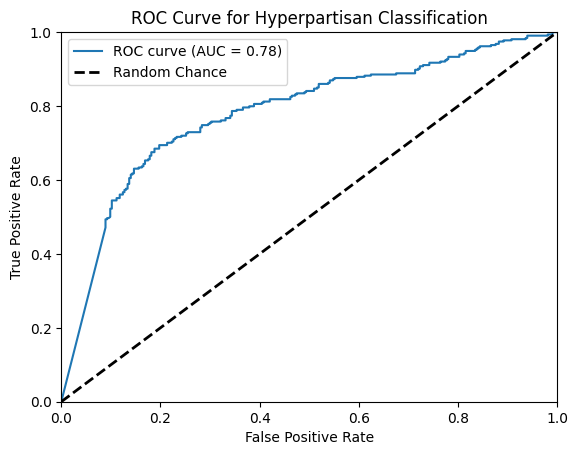

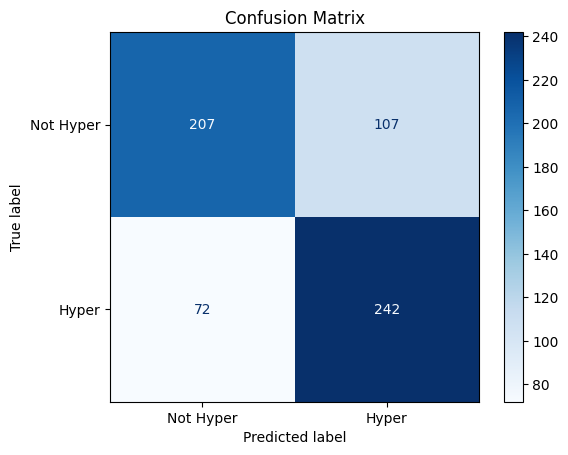

In [88]:
vectorizer = CountVectorizer(stop_words="english", max_features=10000)

# Combine
X_train_comb, X_test_comb = combine_text_and_style(
    vectorizer,
    X_train_text, X_test_text,
    X_train_style, X_test_style
)

# === Oversample training data & NB model ===
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_comb, y_train)

model, y_pred = naive_bayes(X_train_resampled, X_test_comb, y_train_resampled)
y_proba = model.predict_proba(X_test_comb)[:, 1]


# === Evaluate ===
print("\n--- Naive Bayes + CountVectorizer + Style + ROS ---")
metrics(y_test, y_pred, y_proba)
plot_confusion_matrix(y_test, y_pred)
store_metrics(results, "Naive Bayes", "CountVectorizer + Style + ROS + lemmatization", y_test, y_pred, y_proba)

In [89]:
results_df = pd.DataFrame(results)
print("\n=== Final Comparison Table ===")
print(results_df)



=== Final Comparison Table ===
         Model                                          Setup  Accuracy  \
0  Naive Bayes                                         TF-IDF     0.540   
1  Naive Bayes                                CountVectorizer     0.720   
2  Naive Bayes                                   TF-IDF + ROS     0.683   
3  Naive Bayes                          CountVectorizer + ROS     0.715   
4  Naive Bayes                           TF-IDF + Style + ROS     0.686   
5  Naive Bayes                  CountVectorizer + Style + ROS     0.717   
6  Naive Bayes           TF-IDF + Style + ROS + lemmatization     0.680   
7  Naive Bayes  CountVectorizer + Style + ROS + lemmatization     0.715   

   Balanced Accuracy  Precision  Recall  F1 Score    AUC  
0              0.540      0.857   0.096     0.172  0.753  
1              0.720      0.698   0.774     0.734  0.788  
2              0.683      0.631   0.882     0.736  0.810  
3              0.715      0.698   0.758     0.727  0.776

# Total Summary (for Rapport)

We evaluated several Naive Bayes baselines using combinations of text vectorization (TF-IDF, CountVectorizer), class balancing (Random Oversampling), stylistic features (e.g., uppercase ratio, exclamations, sentence length), and optional lemmatization.

The best overall result was achieved with TF-IDF + Style + ROS + Lemmatization, reaching an F1 score of 0.739 and an AUC of 0.815. This setup combined:

    TF-IDF to highlight meaningful, rare terms,

    Stylistic features to capture writing patterns typical of hyperpartisan content,

    ROS to mitigate class imbalance,

    and lemmatization to reduce vocabulary noise.

Interestingly, CountVectorizer-based models performed competitively (F1 = 0.728–0.730), but TF-IDF generally provided better recall and AUC, which are critical when aiming to detect as many hyperpartisan cases as possible, even under noisy conditions.

Lemmatization provided a small boost, especially to recall (e.g., 0.904 in TF-IDF + Style + ROS + Lemmatization), suggesting it helps the model generalize over varied word forms.

We selected Naive Bayes with TF-IDF + Style + ROS + Lemmatization as the best baseline configuration due to its strong F1 and AUC, excellent recall, and robustness to imbalance. This model will serve as the baseline for future comparisons and potential deployment for large-scale or weak labeling tasks.


.....

Although Naive Bayes is often theoretically well-matched with CountVectorizer due to its probabilistic formulation, our experiments found that TF-IDF consistently performed better. This is likely because TF-IDF better highlights informative, rare terms while downweighting common, less relevant words — a crucial distinction in hyperpartisan text, which often relies on emotionally charged or unique phrasing. Additionally, TF-IDF's natural normalization acts as a soft regularizer, helping prevent overfitting on frequent but uninformative terms in a moderately sized dataset. This effect is further enhanced when combined with stylistic features, class balancing, and lemmatization.

In [91]:
result = [row for row in results if row["Setup"] == "TF-IDF + Style + ROS + lemmatization"]
df_single = pd.DataFrame(result)
df_single.to_csv("byarticleBaseline_results_sepTest.csv", index=False)